In [1]:
import numpy as np
import numpy.fft as nf
import matplotlib.pyplot as plt
import wave

In [2]:
# read the wave file and the corresponding parameters
def wave_read(file_name):
    file = wave.open(file_name)
    params = file.getparams() # read the parameters
    nchannels, sampwidth, framerate, nframes = params[:4]
    
    # Reads the complete frame data into str_data, which is a string type
    str_data = file.readframes(nframes)
    # Convert the audio waveform data to an array
    wave_data =  np.frombuffer(str_data, dtype = np.short)
    
    # time is an array paired with wave_data
    time = np.arange(0,nframes) * (1.0/ framerate)
    
    return nchannels, sampwidth, framerate, nframes, wave_data, time


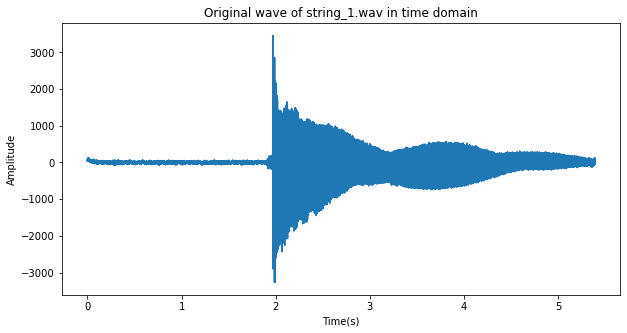

In [3]:
# read the file
nchannels, sampwidth, framerate, nframes, wave_data, time = wave_read("string_1.wav")
    
# plot the wave in time domain
plt.figure(figsize = (10,5))
plt.plot(time, wave_data)
plt.xlabel("Time(s)")
plt.ylabel("Amplitude") 
plt.title("Original wave of "+ "string_1.wav" +" in time domain")
plt.show()

# FIR Delay Effect

The FIR filter for delay effect can be implement thanks to the following input-output equation:

$s[t] = s[t] + \alpha * e[t-D]$

where $\alpha \geq 0$ is the attenuation factor, and $D$ the time delay.

In [17]:
import scipy.signal as signal

## Determine the impulse response

We know that for FIR filter, it have a single impulse applied at k = 1, which will yield a finite length impulse response. Here, we plotted the the implitude response of FIR, who have an 1.5 times amplitude at the end(here Equivalent to setting the parameter $\alpha = 1.5$).

In [18]:
# parameters
D1 = 1 * framerate  # time delay
alpha1 = 1.5

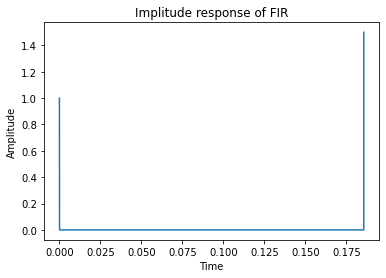

In [19]:
# generate the impulse response
imp = np.zeros(D1+1)
imp[0] = 1
imp[D1] = alpha1
x = np.arange(D1+1)/nframes

# plot the impulse reponse
plt.figure()
plt.plot(x, np.abs(imp))
plt.title("Implitude response of FIR")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

## Determnine the frequency response

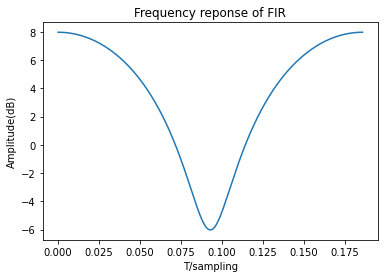

In [20]:
# We can generate the frequency response directly through the impulse response that we generated
freq = nf.fft(imp)

# plot the frequency response
plt.figure()
plt.plot(x, 20*np.log10(np.abs(freq)))
plt.title("Frequency reponse of FIR")
plt.xlabel("T/sampling")
plt.ylabel("Amplitude(dB)")
plt.show()

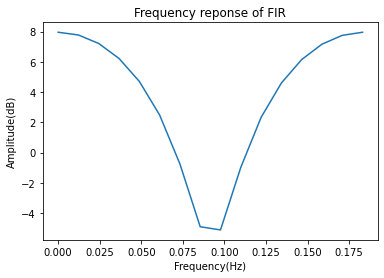

In [21]:
# We can also determine the frequency response through "signal.freqz" function:
A1 = np.zeros(D1+1)
A1[0] = 1
A1[D1] = alpha1

w1, h1 = signal.freqz(A1, fs = 12.5) # frequencies, frequency response

plt.figure()
plt.plot(w1[:16], 20*np.log10(np.abs(h1)[:16]))
plt.title("Frequency reponse of FIR")
plt.xlabel("Frequency(Hz)")
plt.ylabel("Amplitude(dB)")
plt.show()

## Implement the delay effect in the time domain

I implemented the delay effect manually and also directly by "signal.lfilter" and obtained the same result. In the following image: the red wave presents the original wave and the blue one present the generated wave by FIR filter. We can note that FIR filter can perform as an audio echo filter that repeats a sound after a given delay attenuating the repetitions. 


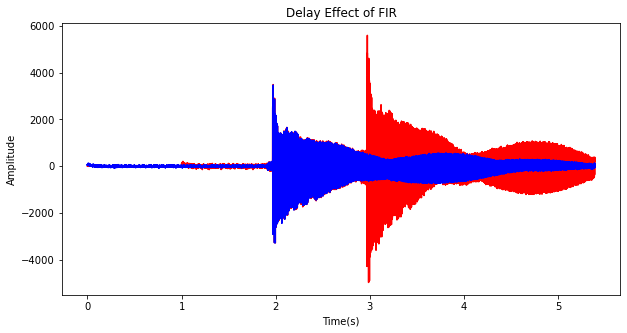

In [22]:
# implement the input-output equation of FIR
fir_s1 = np.zeros(nframes)
for t in range(nframes):
    if t >= D1:
        fir_s1[t] = wave_data[t] + alpha1 * wave_data[t-D1]

# plot the figure
plt.figure(figsize = (10,5))
plt.title("Delay Effect of FIR")
plt.xlabel("Time(s)")
plt.ylabel("Amplitude")
plt.plot(time, fir_s1, 'r')
plt.plot(time, wave_data, 'b')

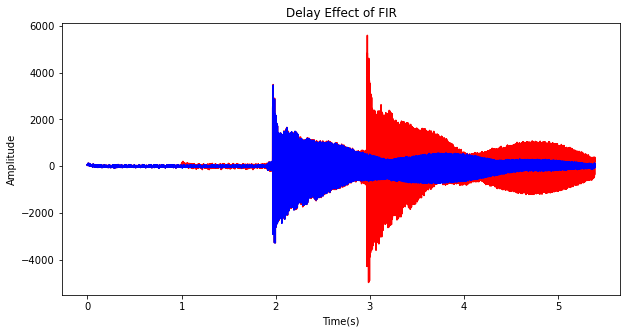

In [23]:
fir_s2 = signal.lfilter(A1, 1, wave_data)

# plot thr figure
plt.figure(figsize = (10,5))
plt.title("Delay Effect of FIR")
plt.xlabel("Time(s)")
plt.ylabel("Amplitude")
plt.plot(time, fir_s2, 'r')
plt.plot(time, wave_data, 'b')

# IIR Delay Effect

## Determine the frequency response

In [24]:
# parameters
alpha2 = 1
beta2 = 1.5 # 
D2 = 1 * framerate # delay time

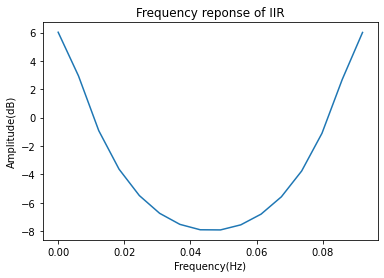

In [25]:
# frequency response
A2 = np.zeros(D2+1)
A2[0] = 1
A2[D2] = - beta2
B2 = [alpha2]

w2, h2 = signal.freqz(B2, A2)

# plot the figure
plt.figure()
plt.plot(w2[:16], 20*np.log10(np.abs(h2[:16])))
plt.title("Frequency reponse of IIR")
plt.xlabel("Frequency(Hz)")
plt.ylabel("Amplitude(dB)")
plt.show()

## Implement the delay effect in the time domain

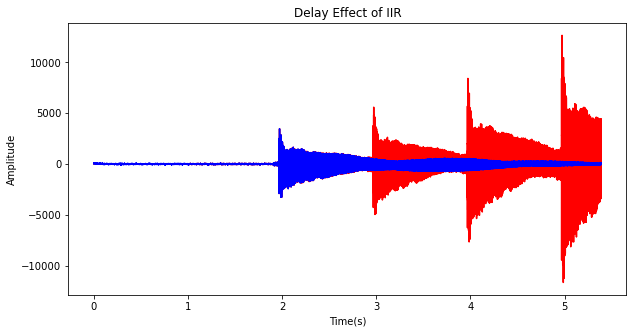

In [26]:
# implement the input-output equation of IIR
iir_s1 = np.zeros(nframes)
for t in range(nframes):
    if t >= D2:
        iir_s1[t] = alpha2 * wave_data[t] + beta2 * iir_s1[t-D2]

# plot the delay effect of IIR
plt.figure(figsize = (10,5))
plt.title("Delay Effect of IIR")
plt.xlabel("Time(s)")
plt.ylabel("Amplitude")
plt.plot(time, iir_s1, 'r')
plt.plot(time, wave_data, 'b')

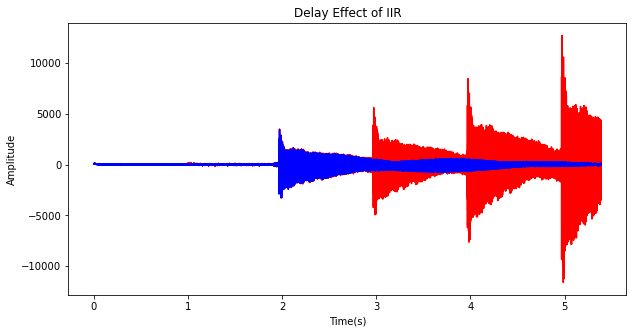

In [27]:
iir_s2 = signal.lfilter(B2, A2, wave_data)

# plot the delay effect of IIR
plt.figure(figsize = (10,5))
plt.title("Delay Effect of IIR")
plt.xlabel("Time(s)")
plt.ylabel("Amplitude")
plt.plot(time, iir_s2, 'r')
plt.plot(time, wave_data, 'b')

## Stable or not?

The IIR filter can be thought as a combination of several sub-filters through which the original wave needs to be filtered in turn in the time domain, so that if any of the sub-filters is unstable, the whole filter is unstable.
It's not always stable. If $\beta \geq 1$, y(n) will not converge and there will always be an overflow. Only $\beta < 1$, the nth power of $\beta$, will converge to 0 as n increases.

## Discuss the parameters

In [28]:
# set the parameters
Alpha1 = 1
Alpha2 = 2
Beta1 = 0.5
Beta2 = 1.5 

D2 = 1 * framerate # delay time

a1 = np.zeros(D2+1)
a1[0] = 1
a1[D2] = - Beta1

a2 = np.zeros(D2+1)
a2[0] = 1
a2[D2] = - Beta2

b1 = [Alpha1]
b2 = [Alpha2]

### choose of $\beta$

When $\beta$ chosen is less than 1, it has a weakening effect on the amplitude of the audio wave. Conversely, when the $\beta$ value is greater than 1, it has an increasing effect(see the result in the following).

In [29]:
# 
beta_res_1  = signal.lfilter(b2, a1, wave_data)
beta_res_2 = signal.lfilter(b2, a2, wave_data)

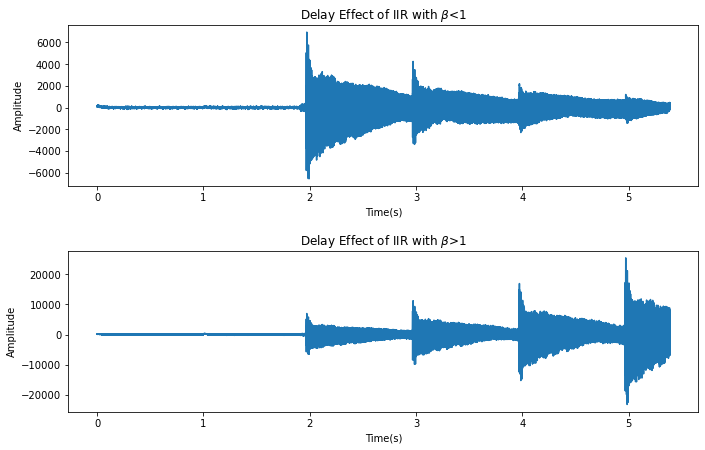

In [30]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize = (10,5))

ax1.plot(time, beta_res_1)
ax1.set_title("Delay Effect of IIR with " + r'$\beta$' + "<1")
ax1.set_xlabel("Time(s)")
ax1.set_ylabel("Amplitude")

ax2.plot(time, beta_res_2)
ax2.set_title("Delay Effect of IIR with " + r'$\beta$' + ">1")
ax2.set_xlabel("Time(s)")
ax2.set_ylabel("Amplitude")

plt.subplots_adjust(left=0.125,
                    bottom=0.125, 
                    right=1, 
                    top=1.2, 
                    wspace=0.3, 
                    hspace=0.4)
plt.show()

### choose of $\alpha$

The value of $\alpha$ influence the value of amplitude of wave. The larger the value of alpha, the larger the corresponding magnitude, and vice versa.

In [31]:
alpha_res_1  = signal.lfilter(b1, a1, wave_data)
alpha_res_2 = signal.lfilter(b2, a1, wave_data)

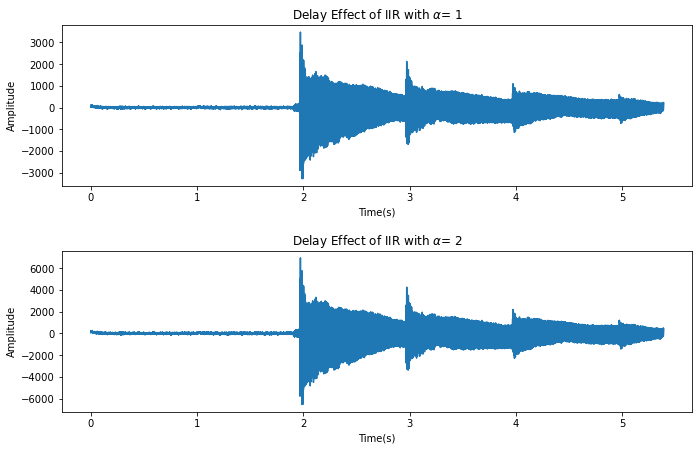

In [32]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize = (10,5))

ax1.plot(time, alpha_res_1)
ax1.set_title("Delay Effect of IIR with " + r'$\alpha$' + "= 1")
ax1.set_xlabel("Time(s)")
ax1.set_ylabel("Amplitude")

ax2.plot(time, alpha_res_2)
ax2.set_title("Delay Effect of IIR with " + r'$\alpha$' + "= 2")
ax2.set_xlabel("Time(s)")
ax2.set_ylabel("Amplitude")

plt.subplots_adjust(left=0.125,
                    bottom=0.125, 
                    right=1, 
                    top=1.2, 
                    wspace=0.3, 
                    hspace=0.4)
plt.show()

## Compare with the FIR implementation

To compare with the FIR implementation, I transfered the original wave in the time domain into the frequency domain by fourier transform. Then I plotted the spectrum of the input and output signals with positive part(see the result figures in the following).

By looking at the frequency domain waveforms of the FIR filtered audio signal(the red one) and the original signal(the blue one), it can be seen that the spectrum waveforms become clearer, but the amplitude is attenuated. By looking at the spectrum after the IIR filter, it can be seen that the spectrum becomes clearer like the FIR filter, but the amplitude is not as significantly attenuated as FIR, and the amplitude and frequency performance is better than the FIR filter.

In [33]:
# do the fourier transform of the original wave and the waves obtained respectively by FIR and IIR
wave_freqs = nf.fftfreq(wave_data.size)
wave_pows = np.abs(nf.fft(wave_data))
wave_pows = np.abs(wave_pows/wave_pows.size) # normalisation

fir_freqs = nf.fftfreq(fir_s1.size)
fir_pows = np.abs(nf.fft(fir_s1))
fir_pows = np.abs(fir_pows/fir_pows.size) # normalisation

iir_freqs = nf.fftfreq(iir_s1.size)
iir_pows = np.abs(nf.fft(iir_s1))
iir_pows = np.abs(iir_pows/iir_pows.size) # normalisation

### Spectrum of input and output signals generated with FIR

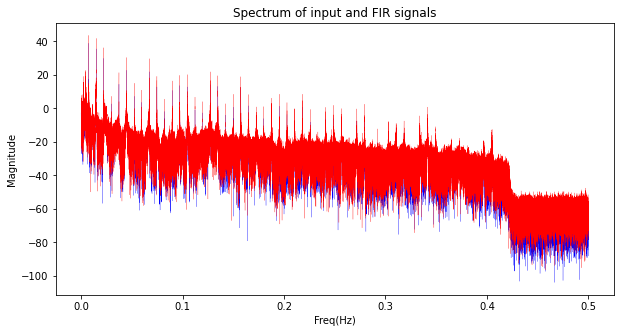

In [34]:
# plot the spectrogram
plt.figure(figsize = (10,5))
plt.plot(wave_freqs[np.where(wave_freqs > 0)], 20*np.log10(wave_pows[np.where((wave_freqs > 0))]),linewidth=0.2, color = 'b')
plt.plot(fir_freqs[np.where(fir_freqs > 0)], 20*np.log10(fir_pows[np.where((fir_freqs > 0))]), linewidth=0.2, color = 'r')

plt.xlabel("Freq(Hz)")
plt.ylabel("Magnitude") 
plt.title("Spectrum of input and FIR signals")
plt.show()

###  Spectrum of input and output signals generated with IIR

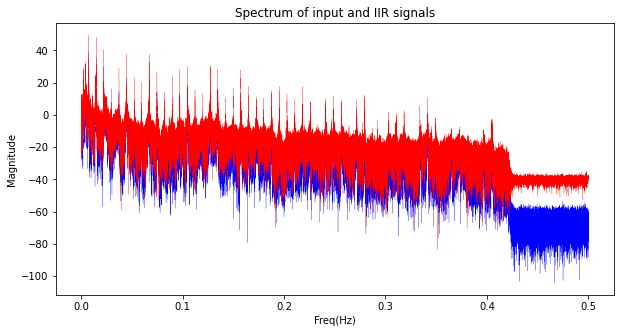

In [35]:
# plot the spectrogram
plt.figure(figsize = (10,5))
plt.plot(wave_freqs[np.where(wave_freqs > 0)], 20*np.log10(wave_pows[np.where((wave_freqs > 0))]), linewidth=0.2, color = 'b')
plt.plot(iir_freqs[np.where(iir_freqs > 0)], 20*np.log10(iir_pows[np.where((iir_freqs > 0))]), linewidth=0.2, color = 'r')
plt.xlabel("Freq(Hz)")
plt.ylabel("Magnitude") 
plt.title("Spectrum of input and IIR signals")
plt.show()

# Image filtering

In [36]:
import cv2

Text(0.5, 1.0, 'Original image')

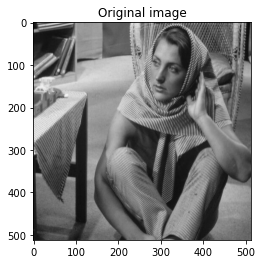

In [37]:
gray_img = cv2.imread('barbara.jpg', 0) # read the gray image

plt.imshow(gray_img, 'gray')
plt.title('Original image')

## Gradient filter

The gradient of an image is a vector of it's partials:

$\nabla f=\left[\begin{array}{l}g_{x} \\ g_{y}\end{array}\right]=\left[\begin{array}{l}\frac{\partial f}{\partial x} \\ \frac{\partial f}{\partial y}\end{array}\right]$

where:

$\frac{\partial f(x, y)}{\partial x}=f(x+\Delta x, y)-f(x, y)$

$\frac{\partial f(x, y)}{\partial y}=f(x, y+\Delta y)-f(x, y)$

When we considering a $3\times3$ kernel:
$$
\begin{array}{|l|l|l|}
\hline \mathrm{Z}_{1} & \mathrm{Z}_{2} & \mathrm{Z}_{3} \\
\hline \mathrm{Z}_{4} & \mathrm{Z}_{5} & \mathrm{Z}_{6} \\
\hline \mathrm{Z}_{7} & \mathrm{Z}_{\mathrm{s}} & \mathrm{Z}_{9} \\
\hline
\end{array}
$$
The gradients will be defined as:

Horizontal direction: $g_{x}=\frac{\partial f}{\partial x}=\left(z_{7}+z_{8}+z_{9}\right)-\left(z_{1}+z_{2}+z_{3}\right)$

Vertical direction: $g_{y}=\frac{\partial f}{\partial y}=\left(z_{3}+z_{6}+z_{9}\right)-\left(z_{1}+z_{4}+z_{7}\right)$

Diagonal direction: $g_{x}^{\prime}=\left(z_{2}+z_{3}+z_{6}\right)-\left(z_{4}+z_{7}+z_{8}\right)$ and $g_{y}^{\prime}=\left(z_{6}+z_{8}+z_{9}\right)-\left(z_{1}+z_{12}+z_{1}\right)$

Then the Prewitt operator is obtained:

for horizontal direction:
 $P_{1} =  
\left[
 \begin{matrix}
   -1 & -1 & -1 \\
   0 & 0 & 0 \\
   1 & 1 & 1 \\
  \end{matrix}
 \right] $ , 
 
for vertical direction: $P_{2} =  
\left[
 \begin{matrix}
   -1 & 0 & 1 \\
   -1 & 0 & 1 \\
   -1 & 0 & 1 \\
  \end{matrix}
 \right] $ 
 
and for diagonal direction:$P_{3} =  
\left[
 \begin{matrix}
   0 & 1 & 1 \\
   -1 & 0 & 1 \\
   -1 & -1 & 0 \\
  \end{matrix}
 \right] $ and $P_{4} =  
\left[
 \begin{matrix}
   -1 & -1 & 0 \\
   -1 & 0 & 1 \\
   0 & 1 & 1 \\
  \end{matrix}
 \right]$

In [38]:
# realize the Prewitt operator
kernelx = np.array([[-1,-1,-1],[0,0,0],[1,1,1]])
kernely = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])

prewitt_x = cv2.filter2D(gray_img, -1, kernelx)
prewitt_y = cv2.filter2D(gray_img, -1, kernely)

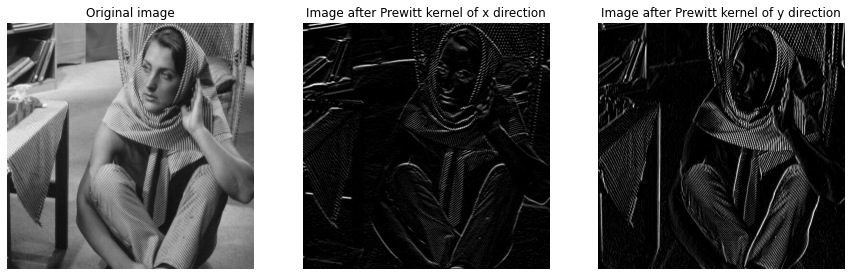

In [39]:
# plot 
figure, ax = plt.subplots(nrows = 1,ncols = 3, figsize = (15,15))

ax.ravel()[0].imshow(gray_img, 'gray')
ax.ravel()[0].set_title('Original image')
ax.ravel()[0].set_axis_off()

ax.ravel()[1].imshow(prewitt_x, 'gray')
ax.ravel()[1].set_title('Image after Prewitt kernel of x direction')
ax.ravel()[1].set_axis_off()

ax.ravel()[2].imshow(prewitt_y, 'gray')
ax.ravel()[2].set_title('Image after Prewitt kernel of y direction')
ax.ravel()[2].set_axis_off()

We can note from the results above that the gradient filter has the effect of extracting the edges of an image.

## Sobel filter

The Sobel operator is an improvement on the Prewitt operator and use a weight of 2 on the central coefficient. Compared to the Prewitt operator, the Sobel template is better able to suppress(smooth) the noise. The Sobel operator is:

for vertical direction:
$S_{1} =  
\left[
 \begin{matrix}
   -1 & 0 & 1 \\
   -2 & 0 & 2 \\
   -1 & 0 & 1 \\
  \end{matrix}
 \right] $  
 
 and for horizontal direction: 
 $S_{2} =  
\left[
 \begin{matrix}
   -1 & -2 & -1 \\
   0 & 0 & 0 \\
   1 & 2 & 1 \\
  \end{matrix}
 \right] $

In [40]:
sobel_x = cv2.Sobel(gray_img,cv2.CV_64F,0,1,ksize=3)
sobel_y = cv2.Sobel(gray_img,cv2.CV_64F,1,0,ksize=3)

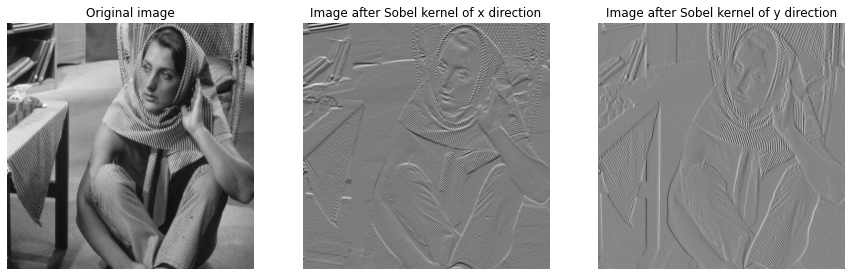

In [41]:
figure, ax = plt.subplots(nrows = 1,ncols = 3, figsize = (15,15))

ax.ravel()[0].imshow(gray_img, 'gray')
ax.ravel()[0].set_title('Original image')
ax.ravel()[0].set_axis_off()

ax.ravel()[1].imshow(sobel_x, 'gray')
ax.ravel()[1].set_title('Image after Sobel kernel of x direction')
ax.ravel()[1].set_axis_off()

ax.ravel()[2].imshow(sobel_y, 'gray')
ax.ravel()[2].set_title('Image after Sobel kernel of y direction')
ax.ravel()[2].set_axis_off()

## Averaging filter

The averaging filtering is a linear filtering and the main method is calculating the neighbourhood averaging and replacing the central pixel values in the original image with the mean value of the individual pixels in a region of the image. A $3\times3$ averaging filter operator is shown:

$A =   
\left[
 \begin{matrix}
   \frac{1}{9} & \frac{1}{9} & \frac{1}{9} \\
   \frac{1}{9} & \frac{1}{9} & \frac{1}{9} \\
   \frac{1}{9} & \frac{1}{9} & \frac{1}{9} \\
  \end{matrix}
 \right] $
 
We could see from the following result that the mean filtering could demoise the image, but at the same time it does not protect the image details well and destroys the detailed parts of the image, thus blurring the image.

In [42]:
blur_img1 = cv2.blur(gray_img,(3,3))

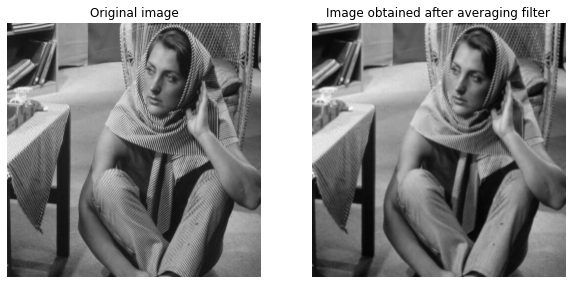

In [43]:
figure, ax = plt.subplots(nrows = 1,ncols = 2, figsize = (10,10))

ax.ravel()[0].imshow(gray_img, 'gray')
ax.ravel()[0].set_title('Original image')
ax.ravel()[0].set_axis_off()

ax.ravel()[1].imshow(blur_img1, 'gray')
ax.ravel()[1].set_title('Image obtained after averaging filter')
ax.ravel()[1].set_axis_off()

## Gaussian filter

Gaussian filter is a linear smoothing filter suitable for removing Gaussian noise and is widely used in the noise reduction process of image processing. It weighted averaging of the entire image, where the value of each pixel is obtained by a weighted average of its own value and the values of other pixels in its neighbourhood.

In [44]:
blur_img2 = cv2.GaussianBlur(gray_img,(3,3),0)

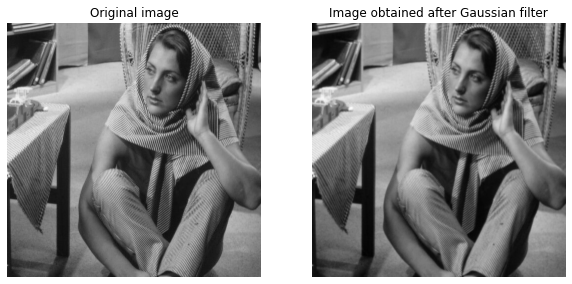

In [45]:
figure, ax = plt.subplots(nrows = 1,ncols = 2, figsize = (10,10))

ax.ravel()[0].imshow(gray_img, 'gray')
ax.ravel()[0].set_title('Original image')
ax.ravel()[0].set_axis_off()

ax.ravel()[1].imshow(blur_img2, 'gray')
ax.ravel()[1].set_title('Image obtained after Gaussian filter')
ax.ravel()[1].set_axis_off()